In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_excel('data.xls')
df = df.loc[:, ['交易日期', '证券代码', '昨日收盘价']]
df = df.rename(columns={'交易日期':'date', '证券代码': 'code', '昨日收盘价': 'price'})

In [4]:
df1 = df[df['code'] == 2324  ].drop(columns=['code']).set_index('date').rename(columns={'price': '002324'})
df2 = df[df['code'] == 2475  ].drop(columns=['code']).set_index('date').rename(columns={'price': '002475'})
df3 = df[df['code'] == 300062].drop(columns=['code']).set_index('date').rename(columns={'price': '300062'})
df = pd.concat([df1, df2, df3], axis=1).dropna()

In [5]:
# 计算对数收益率
Returns = np.log(df / df.shift(1))
# 丢弃缺失值
Returns.dropna(inplace=True)

In [6]:
Returns.head()

,002324,002475,300062
date,,,
1/4/2017,0.014628,-0.062132,0.033851
1/5/2017,0.004610,0.031797,0.032457
1/6/2017,-0.006592,-0.010989,-0.003142
1/9/2017,-0.021729,-0.008575,0.022625
1/10/2017,-0.005762,-0.001521,0.074607


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

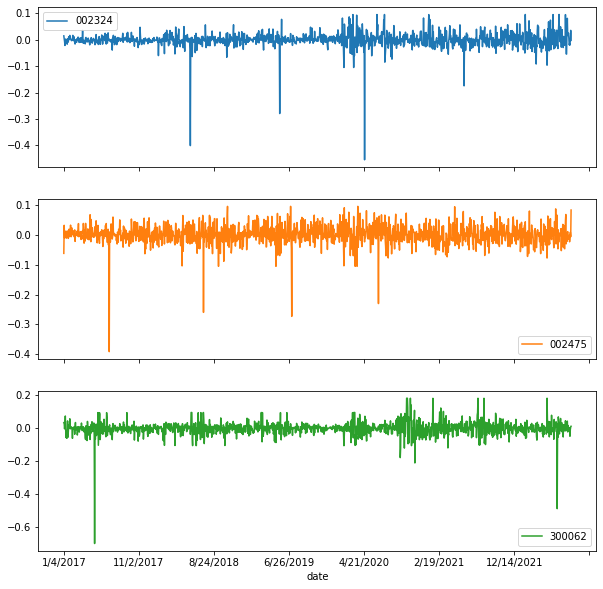

In [7]:
Returns.plot(subplots=True, figsize=(10, 10))

In [8]:
returns = Returns.copy()

In [9]:
portfolio_weights = np.array([0.33, 0.33, 0.33])
# 设置投资权重
WeightedReturns = returns.mul(portfolio_weights, axis=1)
# 计算投资组合的收益
Returns['Portfolio'] = WeightedReturns.sum(axis=1)

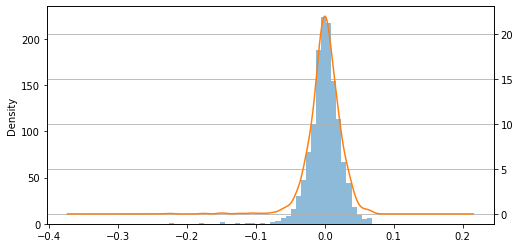

In [10]:
import matplotlib.pyplot as plt

# 正态检验直方图
s = Returns['Portfolio']
fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot()
s.hist(bins=40, alpha=0.5, ax=ax)
s.plot(kind='kde', secondary_y=True, ax=ax)
plt.grid()

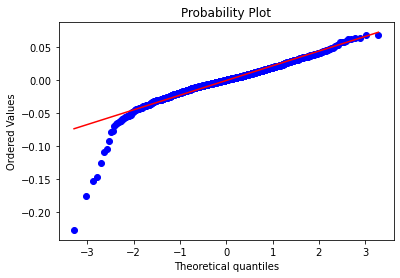

In [11]:
from scipy import stats

# 正态检验性---QQ图
stats.probplot(Returns['Portfolio'], dist="norm", plot=plt)
plt.show()

In [12]:
from scipy.stats import kstest

#正态性检验——KS检验
u = Returns['Portfolio'].mean()
std = Returns['Portfolio'].std()
kstest(Returns['Portfolio'], 'norm', (u, std))

KstestResult(statistic=0.07647212863668124, pvalue=2.532505144271746e-07)

In [13]:
from scipy.stats import norm

conf_level1 = 0.01  # 选择置信度为99%
initial_investment = 1000000  # 初始投资是100万
cov_matrix = returns.cov()  # 协方差矩阵
avg_rets = returns.mean()
port_mean = avg_rets.dot(portfolio_weights)  # 投资组合的均值
port_stdev = np.sqrt(portfolio_weights.T.dot(cov_matrix).dot(portfolio_weights))  # 投资组合方差
mean_investment = (1+port_mean) * initial_investment
stdev_investment = initial_investment * port_stdev  # 投资组合方差（绝对值）
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
var_1d1 = initial_investment - cutoff1


In [14]:
list_evar = []  # 边际VaR
list_cvar = []  # 成分VaR
i = 0
total_cvar = 0
for ticker in ['002324', '002475', '300062']:
    evar = var_1d1 / initial_investment * \
        (Returns['Portfolio'].cov(Returns[ticker]) / pow(port_stdev, 2))
    list_evar.append(evar)
    cvar = evar * initial_investment * portfolio_weights[i]
    list_cvar.append(cvar)
    total_cvar = cvar+total_cvar
    i = i + 1

In [22]:
list_percent = ['{:.2%}'.format(i / np.sum(list_cvar)) for i in list_cvar]

In [24]:
ans = pd.DataFrame([list_evar, list_cvar, list_percent])

ans.rename(index={0:'边际VaR', 1:'成分VaR', 2: '成分VaR贡献'}, inplace=True)
ans.rename(columns={0: '002345', 1: '002475', 2: '300062'}, inplace=True)

In [25]:
ans

,002345,002475,300062
边际VaR,0.040406,0.049503,0.075778
成分VaR,13334.137832,16335.838562,25006.890435
成分VaR贡献,24.39%,29.88%,45.74%
